In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from math import sqrt, pi,exp,log2
from random import random
from hilbertcurve.hilbertcurve import HilbertCurve

def norm_pdf(Y,mu,sig):
    return(np.exp((-(Y-mu)**2)/(2*sig**2))/(sqrt(2*pi)*sig))
def multi_norm_pdf(y,mu,sig):
    return(np.exp(-0.5*(Y-mu)@np.linalg.inv(sig)@(Y-mu))/((2*pi)**mu.shape[0]*sqrt(abs(numpy.linalg.det(sig)))))

In [2]:
class Markov_Chain:
    
    def __init__(self,chain=np.array([])):
        self.chain=chain
        self.n=self.chain.shape[0]
        
    def init_from_image(self,image):
        mat=np.asarray(image,)
        n=len(mat)
        chaine=np.zeros(n*n,dtype='int64')
        hilbert_curve=HilbertCurve(int(log2(n)),2)
        for i in range(n):
            for j in range(n):
                chaine[hilbert_curve.distance_from_coordinates([i,j])]=mat[i][j]
        self.chain=chaine
        self.n=chaine.shape[0]
        
    def get_image(self):
        n=len(self.chain)
        m=int(sqrt(n))
        mat=np.zeros((m,m))
        hilbert_curve=HilbertCurve(int(log2(n)),2)
        for i in range(n):
            coor=hilbert_curve.coordinates_from_distance(i)
            mat[coor[0]][coor[1]]=self.chain[i]
        return (mat)
        
    def plot_image(self,title=None,show=True):
        plt.title(title)
        plt.imshow(self.get_image(),cmap='Greys_r')
        if show:
            plt.show()

    def get_category(self):
        classes=np.unique(self.chain)
        return(classes)
    
    def error_rate(self,B):
        mean=np.mean(np.abs(self.chain-B)/255)
        return(min(mean,1-mean)) 

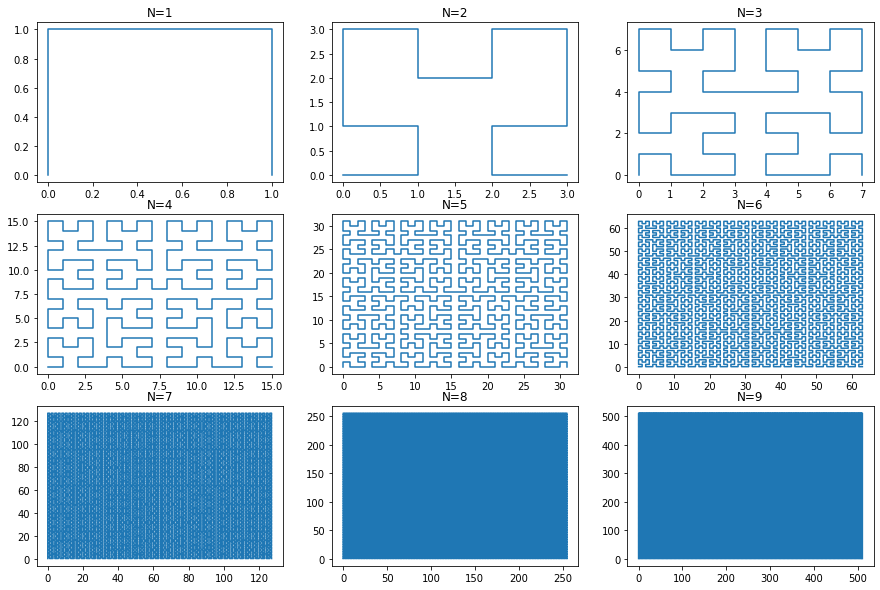

In [9]:
fig=plt.figure(figsize=(15,10))
for i in range(1,10):
    fig.add_subplot(3,3,i)
    N=2**(i)
    hilbert_curve=HilbertCurve(int(log2(N)),2)
    coords=np.zeros((N**2,2))
    for j in range(N**2):
        coords[j]=hilbert_curve.coordinates_from_distance(j)
    plt.title("N="+str(i))
    plt.plot(coords[:,0],coords[:,1])

In [29]:
class CMC(Markov_Chain):
    def __init__(self,chain=np.array([])):
        
        super().__init__(chain)
    
    def gaussian_noise(self,classes,mean,std):
        nb_classes=classes.shape[0]
        
        gauss=[]
        for i in range(nb_classes):
            gauss+=[np.random.normal(mean[i],std[i],self.n)]
        bruit=np.zeros((nb_classes,self.n))
        for i in range(nb_classes):
            bruit[i]=np.where(self.chain==classes[i],gauss[i],0)
        return(CMC(bruit.sum(axis=0)))
    
    def compute_true_transition(self,classes):
        
        X=self.chain
        nb_classes=classes.shape[0]
        index_classes=dict()
        for i in range(nb_classes):
            index_classes[classes[i]]=i
        transitions=np.zeros((nb_classes,nb_classes))
        x_list=X.tolist()
        for (i,j) in zip(x_list,x_list[1:]):
            transitions[index_classes[int(i)]][index_classes[int(j)]]+=1
        transitions=(transitions.T/transitions.sum(axis=1)).T
        return(transitions)

    def gaussian_assumption(self,mean,std):
        
        nb_classes=mean.shape[0]
        gaussians=np.zeros((nb_classes,self.n))
        for i in range(nb_classes):
            gaussians[i]=norm_pdf(self.chain,mean[i],std[i])
        return(gaussians)

    def forward(self,gaussians,n,transitions,p):
        
        nb_classes=transitions.shape[0]
        alpha=np.zeros((nb_classes,n))
        alpha[:,0]=p*gaussians[:,0]
        alpha[:,0]=alpha[:,0]/(alpha[:,0].sum())
        for i in range(1,n):
            alpha[:,i]=gaussians[:,i]*np.transpose(alpha[:,i-1])@transitions
            alpha[:,i]=alpha[:,i]/(alpha[:,i].sum())
        return alpha
    
    def backward(self,gaussians,n,transitions):
        nb_classes=transitions.shape[0]
        beta=np.zeros((nb_classes,n))
        beta[:,0]=np.ones(nb_classes)
        beta[:,0]=beta[:,0]/(beta[:,0].sum())
        for i in range(1,n):
            beta[:,i]=gaussians[:,i]*np.transpose(beta[:,i-1])@transitions
            beta[:,i]=beta[:,i]/(beta[:,i].sum())
        return beta
    
    def baum_welch(self,p0,transitions0,mean0,std0,nb_iter):
        
        p,transitions,mean,std=p0,transitions0,mean0,std0
        t=self.n
        Y=self.chain
        
        for _ in range(nb_iter):
            
            gaussians=self.gaussian_assumption(mean,std)
            alpha=self.forward(gaussians,t-1,transitions,p)
            beta=self.backward(gaussians,t,transitions)
            
            gamma=alpha[np.newaxis,:,:]*gaussians[:,np.newaxis,1:]*beta[:,np.newaxis,1:]*transitions[:,:,np.newaxis]
            gamma=gamma/(gamma.sum(axis=0).sum(axis=0))
            psi=gamma.sum(axis=0)
            
            transitions=(gamma.sum(axis=2))/(psi.sum(axis=1))
            mean=((psi*Y[np.newaxis,:-1]).sum(axis=1))/(psi.sum(axis=1))
            std=np.sqrt(((psi*(Y[np.newaxis,:-1]-mean[:,np.newaxis])**2).sum(axis=1))/(psi.sum(axis=1)))
            p=psi[:,0]
                       
        return(p,transitions,mean,std)
    
    def MPM(self,classes,transitions0,p0,mean0,std0,nb_iter_bw=10):
        
        #Parameter Estimation
        p,transitions,mean,std=self.baum_welch(p0,transitions0,mean0,std0,nb_iter_bw)
        print(p,transitions,mean,std)
        
        # Prediction
        gaussians=self.gaussian_assumption(mean,std)
        alpha=self.forward(gaussians,self.n,transitions,p)
        beta=self.backward(gaussians,self.n,transitions)
        X_apost=np.zeros(self.n)
        p=alpha*beta
        classes_pmax=np.argmax(p,axis=0)
        
        return CMC(classes[classes_pmax])

[1.25081436e-04 9.99874919e-01] [[1.00000000e+00 2.48743177e-11]
 [3.29792860e-12 1.00000000e+00]] [1.04129785 2.88437188] [1.03263972 1.10099196]


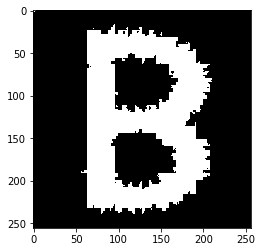

In [30]:
image_chain = CMC()
image_chain.init_from_image(np.array(Image.open('./images/beee2.bmp')))
classes = image_chain.get_category()
mean=np.array([1,3])
std=np.array([1,1])
p=np.array([0.5,0.5])
image_bruite=image_chain.gaussian_noise(classes,mean,std)
transitions=image_chain.compute_true_transition(classes)
mean0=np.array([0.5,4])
std0=np.array([2,0.5])
p0=np.array([0.5,0.5])
image_segmente=image_bruite.MPM(classes,transitions,p0,mean,std,10)
image_segmente.plot_image()

In [28]:
a=np.array([[1,2,3],[4,5,6]])
b=np.array([[7,8,9],[10,11,12]])
c=np.random.randn(2,2)

print(a)
print('b='+str(b))
cross=a[np.newaxis,:,:]*b[:,np.newaxis,:]
print('cross='+str(cross[:,0,0]))

# print('c='+str(c))

# double=cross*c[:,:,np.newaxis]
# print(double[:,:,0])

[[1 2 3]
 [4 5 6]]
b=[[ 7  8  9]
 [10 11 12]]
cross=[ 7 10]


In [ ]:
class CMCouple(Markov_Chain):
    def __init__(self,chain=np.array([]),classes):
        
        super().__init__(chain)
        self.classes=classes
        self.nb_classes=classes.shape[0]
        self.index_classes=dict()
        for i in range(self.nb_classes):
            self.index_classes[self.classes[i]]=i
    
    def gaussian_noise_couple(self,mean,std):
        chaine_bruite=np.zeros(self.n)
        chaine_bruite[0:2]=np.random.multivariate_normal(mean[self.index_classes[self.chain[0]]][self.index_classes[self.chain[1]]],std[self.index_classes[self.chain[0]]][self.index_classes[self.chain[1]]])
        for i in range(2,self.n)
            mean_i=mean[self.index_classes[self.chain[i-1]]][self.index_classes[self.chain[i]]]
            std_i=std[self.index_classes[self.chain[i-1]]][self.index_classes[self.chain[i]]]
            chaine_bruite[i]=np.random.normal(mean_i[1]+std_i[1][0]/std_i[0][0]*(chaine_bruite[i-1]-mean_i[0]),sqrt(std_i[1][1]-std_i[0][1]*std[1][0]/std_i[0][0]))            
        return(CMCouple(chaine_bruite))
    
    def x_joint_true(self):
        
        X=self.chain
        transitions=np.zeros((self.nb_classes,self.nb_classes))
        x_list=X.tolist()
        for (i,j) in zip(x_list,x_list[1:]):
            transitions[self.index_classes[int(i)]][self.index_classes[int(j)]]+=1
        return(transitions)

    def compute_probas_chaine(self,mean,std,x_joint):
        
        transi=np.zeros((self.nb_classes,self.nb_classes,self.n-1))
        p_z_1=np.zeros((self.nb_classes,self.nb_classes))
        for i,j in zip(self.classes.tolist(),self.classes.tolist()):
            p_z_1[self.index_classes[i]][self.index_classes[j]]=norm_pdf(self.chain[0],mean[self.index_classes[i]][self.index_classes[j]][0],std[self.index_classes[i]][self.index_classes[j]][0][0])
        p_z_1=(p_z_1*x_joint).sum(axis=1)
        for k in range(1,self.n-1):
            marginale=np.zeros((self.nb_classes,self.nb_classes))
            for i,j in zip(self.classes.tolist(),self.classes.tolist()):
                marginale[self.index_classes[i]][self.index_classes[j]]=norm_pdf(self.chain[k],mean[self.index_classes[i]][self.index_classes[j]][0],std[self.index_classes[i]][self.index_classes[j]][0][0])
                transi[self.index_classes[i]][self.index_classes[j]][k-1]=multi_norm_pdf(self.chain[k:k+2],mean[self.index_classes[i]][self.index_classes[j]],std[self.index_classes[i]][self.index_classes[j]])
            maginale=(marginale*x_joint).sum(axis=1)
            transi[:,:,k]=transi[:,:,k]*x_joint/marginale
        return(p_z_1,transi)

    def forward(self,n,transitions,p_z_1):
        
        alpha=np.zeros((self.nb_classes,n))
        alpha[:,0]=p_z_1
        alpha[:,0]=alpha[:,0]/(alpha[:,0].sum())
        for i in range(1,n):
            alpha[:,i]=np.transpose(alpha[:,i-1])@transitions[:,:,i-1]
            alpha[:,i]=alpha[:,i]/(alpha[:,i].sum())
        return alpha
    
    def backward(self,n,transitions):
        beta=np.zeros((self.nb_classes,n))
        beta[:,0]=np.ones(self.nb_classes)
        beta[:,0]=beta[:,0]/(beta[:,0].sum())
        for i in range(1,n):
            beta[:,i]=np.transpose(beta[:,i-1])@transitions[:,:,i-1]
            beta[:,i]=beta[:,i]/(beta[:,i].sum())
        return beta
    
    def baum_welch(self,p0,transitions0,mean0,std0,nb_iter):
        
        p,transitions,mean,std=p0,transitions0,mean0,std0
        t=self.n
        Y=self.chain
        
        for _ in range(nb_iter):
            
            gaussians=self.gaussian_assumption(mean,std)
            alpha=self.forward(gaussians,t-1,transitions,p)
            beta=self.backward(gaussians,t,transitions)
            
            gamma=alpha[np.newaxis,:,:]*gaussians[:,np.newaxis,1:]*beta[:,np.newaxis,1:]*transitions[:,:,np.newaxis]
            gamma=gamma/(gamma.sum(axis=0).sum(axis=0))
            psi=gamma.sum(axis=0)
            
            transitions=(gamma.sum(axis=2))/(psi.sum(axis=1))
            mean=((psi*Y[np.newaxis,:-1]).sum(axis=1))/(psi.sum(axis=1))
            std=np.sqrt(((psi*(Y[np.newaxis,:-1]-mean[:,np.newaxis])**2).sum(axis=1))/(psi.sum(axis=1)))
            p=psi[:,0]
                       
        return(p,transitions,mean,std)
    
    def MPM(self,transitions0,p0,mean0,std0,nb_iter_bw=10):
        
        #Parameter Estimation
        p,transitions,mean,std=self.baum_welch(p0,transitions0,mean0,std0,nb_iter_bw)
        print(p,transitions,mean,std)
        
        # Prediction
        gaussians=self.gaussian_assumption(mean,std)
        alpha=self.forward(gaussians,self.n,transitions,p)
        beta=self.backward(gaussians,self.n,transitions)
        X_apost=np.zeros(self.n)
        p=alpha*beta
        classes_pmax=np.argmax(p,axis=0)
        
        return CMC(self.classe[classes_pmax])